In [2]:
import matplotlib.pyplot as plt
import numpy as np
import yfinance as yf
import pandas as pd
import datetime

/Users/antoine/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [3]:
APL = "AAPL"

In [4]:
data = yf.Ticker(APL) # Extraction avec yfinance
prix_rec = data.history(period = '1d', start = '2020-1-1', end = '2023-10-26')
prix_anc = data.history(period = '1d', start = '1980-12-12', end = '2023-10-26')

In [29]:
data # Visualisation des données récuperées 

yfinance.Ticker object <AAPL>

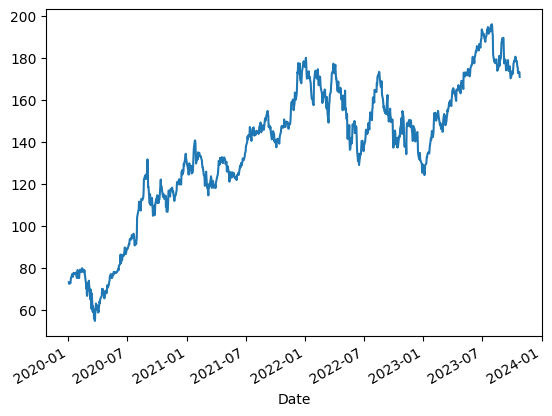

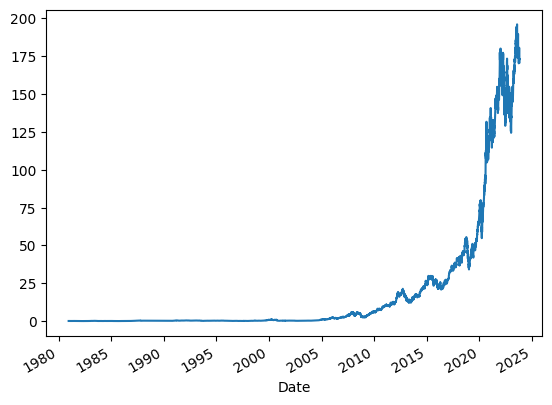

In [6]:
# Première idée des prix de l'action à la fermeture 
prix_rec['Close'].plot() # Depuis 2020
plt.show()

prix_anc['Close'].plot() # Depuis 1980
plt.show()

In [9]:
def plot_series(time, series, format="-", start=0, end=None, label=None): # fonction pour plot toujours comme on veut
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)


In [26]:
df=pd.read_csv("AAPL.csv")  # Passage en pandas 

df['Date']=pd.to_datetime(df['Date']) # On convertit en amont toutes les dates en dates
df = df[df['Date'] >= pd.to_datetime('2020-01-01')] # Puis on ne garde qu'à partir de 2020


In [27]:
# Definition des valeurs qui nous seront utiles plus tard
    
time = np.arange(962)  # Intervalle de temps : tous les jours depuis le 2020-01-01

split_time = 500       # Temps à partir duquel on concentre notre étude
                       # Analogue du temps d'entrainement en machine learning

time_valid = time[split_time:] # Temps de validation du modèle 
x_valid = df['Close'][split_time:] # Partie de la courbe qui nous intéresse 

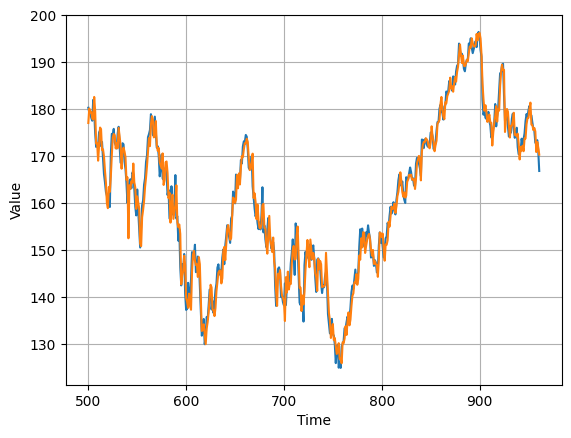

In [28]:
# I - Premières statistiques descriptives sur les valeurs

# Comparaison de valeurs de fermeture et d'ouverture 

x_ouverture = df['Open'][split_time:]
plot_series(time_valid, x_valid)
plot_series(time_valid, x_ouverture)
plt.show()


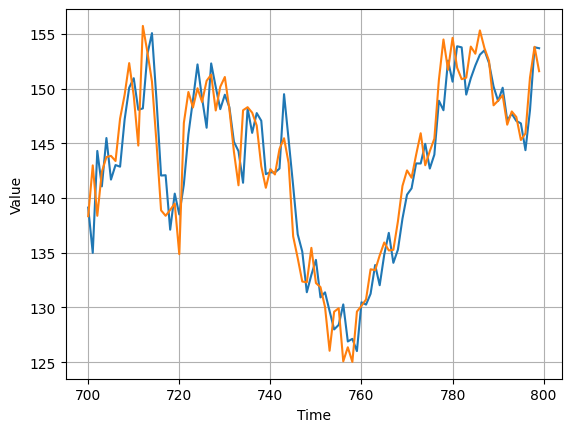

In [30]:
# On peut encore plus zoomer sur des intervalles de temps précis pour percevoir des différences certains jours

plot_series(time[700:800], df['Open'][700:800])
plot_series(time[700:800], df['Close'][700:800])
plt.show()

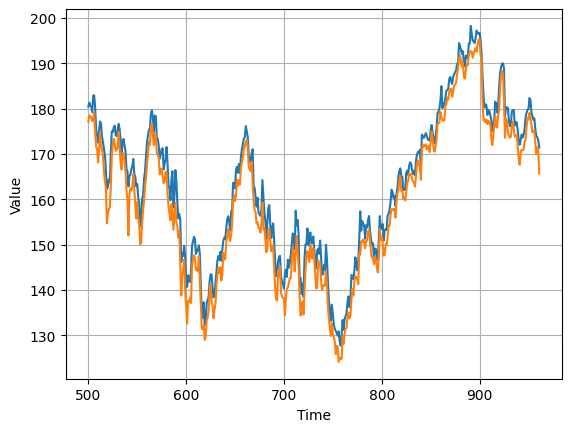

In [31]:
# De même avec les valeurs les plus hautes et les plus basses atteintes chaque jour

plot_series(time[split_time:], df['High'][split_time:])
plot_series(time[split_time:], df['Low'][split_time:])
plt.show()

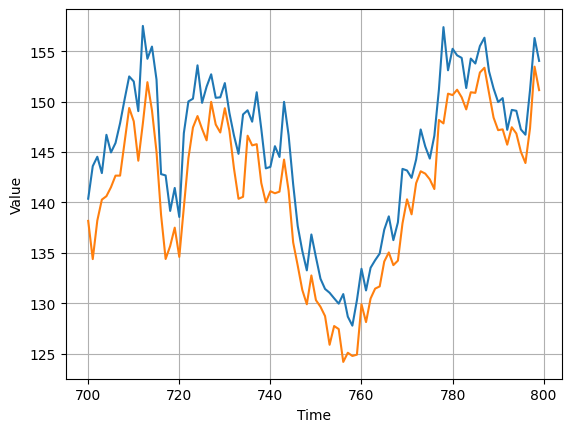

In [32]:
# En zoomant sur un passage intéressant

plot_series(time[700:800], df['High'][700:800])
plot_series(time[700:800], df['Low'][700:800])
plt.show()

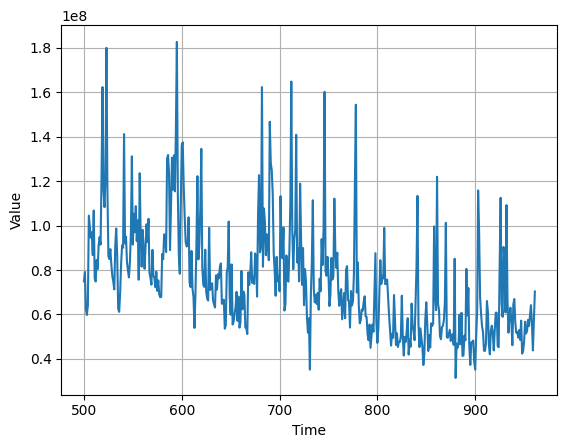

In [33]:
# Intéressons nous enfin au volume de transaction chaque jour

plot_series(time[split_time:], df['Volume'][split_time:])

In [ ]:
# II - Passons maintenant à la modélisation

df = df[['Date', 'Close']] # On ne garde que la variable de close qui est celle qui nous intéresse

df['NumeroLigne'] = df.reset_index().index # Pour indexer le temps, ce qui va nous servir dans le futur

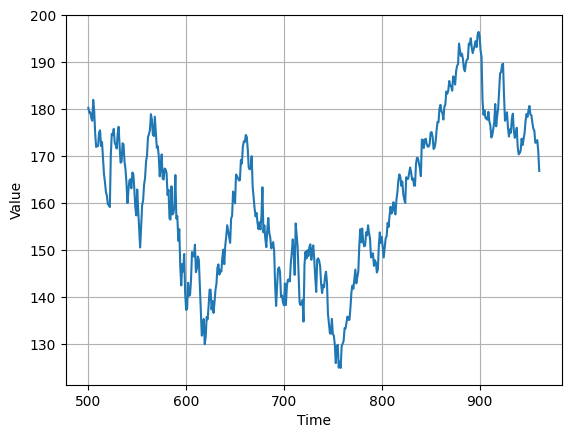

In [15]:
plot_series(time_valid, x_valid) # visualisation du cours de l'action Apple plus récemment

In [16]:
def forecast_moyenne(series, window_size):  # Modèle pour modéliser la valeur future : moyenne des x dernière valeurs
  """La prochaine valeur est la moyenne des 'window_size' dernières valeurs"""
  forecast = []
  for time in range(len(series) - window_size):
    forecast.append(series[time:time + window_size].mean())
  return np.array(forecast)

In [17]:
prix_forecast = forecast_moyenne(df['Close'], 30)[split_time - 30:] # Prédiction de la valeur du prix

# On commence en avance par rapport au temps qui nous intéresse pour pouvoir avoir 'window_size' de temps déja compute
# Ainsi on pourra faire la moyenne des 'window_size' (ici 30) précédentes valeurs pour que à partir de 'split_time'
# les valeurs soient des valeurs crées par notre modèle 

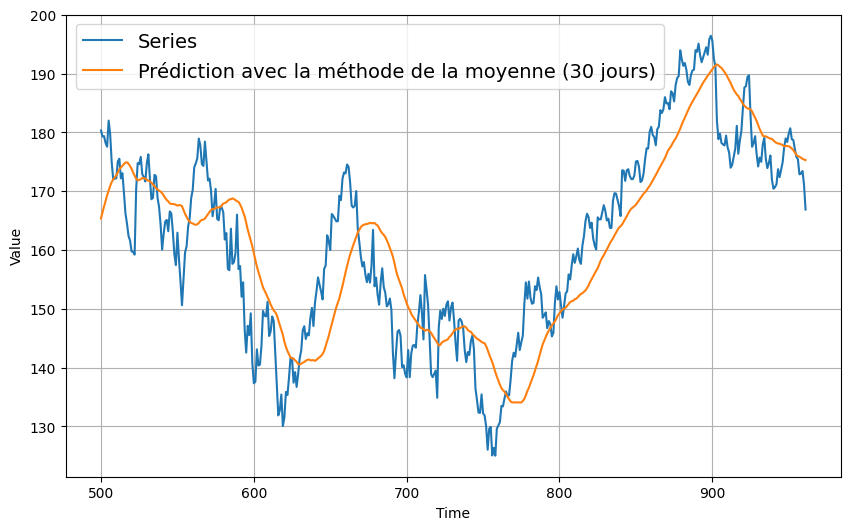

In [18]:
plt.figure(figsize=(10, 6)) # On compare 
plot_series(time_valid, x_valid, label = "Series")
plot_series(time_valid, prix_forecast, label = "Prédiction avec la méthode de la moyenne (30 jours)")

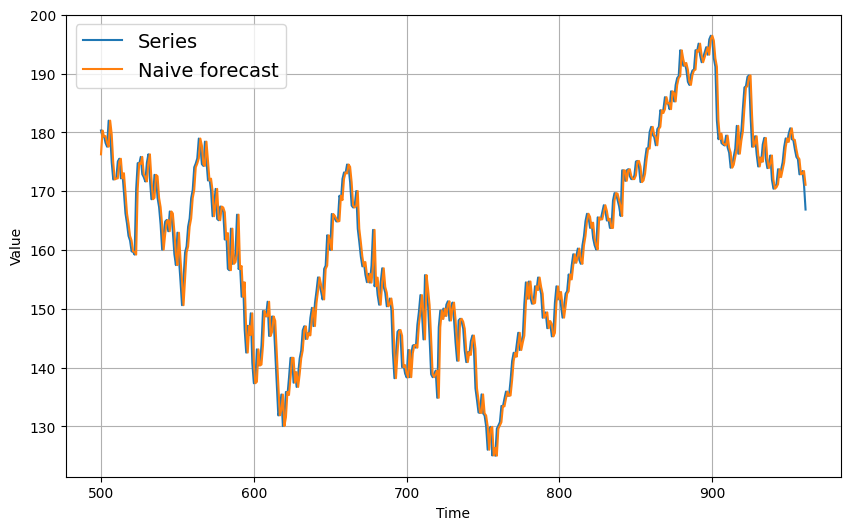

In [35]:
naive_forecast = df['Close'][split_time - 1:-1] # Avec le naive forecast

# Le naive forecast consiste à prédire chaque valeur par la valeur précedente du modèle
# Ici on commence donc à la valeur qui précède l'intervalle qui nous intéresse jusqu'à la fin

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid, label="Series")
plot_series(time_valid, naive_forecast, label= "Naive forecast")

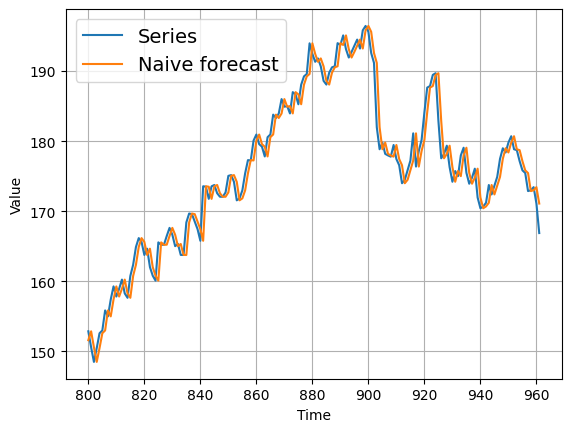

In [36]:
# On zoom sur l'efficacité du naive forecast 

split_time2 = 800
time_naive = time[split_time2:]
x_naive = df['Close'][split_time2:]
naive_forecast2 = df['Close'][split_time2 - 1:-1]
plot_series(time_naive, x_naive, label="Series")
plot_series(time_naive, naive_forecast2, label="Naive forecast")

In [38]:
# Erreur des modèles 
import tensorflow as tf 

# Naive forecast 
print(tf.keras.metrics.mean_absolute_error(x_valid, naive_forecast).numpy())

# Forecast moyen 
print(tf.keras.metrics.mean_absolute_error(x_valid, prix_forecast).numpy())

# Le modèle de naive forecast est très efficace ici, mais on peut tout de même essayer d'aller plus loin à l'aide d'un modèle faisant appel 
# a du machine learning !


2.2220128095238088
7.309727871789324
